# <center> **-- Image Generation Pipeline --** </center>

## <font size="20"> &#10148; </font> Introduction
- This file provides a pipeline to generate face images.
    - A trained DCGAN (that is trained using Train_Enhanced_DCGAN.ipynb) is loaded to generate low-resolution images.
    - A SRGAN model trained by others is used to scale-up the resolution of the generate images.
    


<br/>

## <font size="20"> &#8681; </font> Import

In [467]:
# import
#--------------------------------------------------#
import os 
import sys
import os.path
from sys import platform
from pathlib import Path
#--------------------------------------------------#
import re
import sys
import time
import copy
import math
import html
import scipy
import pickle
import random
import argparse
import subprocess
import numpy as np
import pandas as pd

#--------------------------------------------------#
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init as init
import torchvision.transforms as tt


from torchvision.utils import make_grid
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

#--------------------------------------------------#
import cv2
import PIL
#--------------------------------------------------#
from tqdm.notebook import tqdm

#--------------------------------------------------#
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

#--------------------------------------------------#
from IPython.display import Image
%matplotlib inline





<br/>

## <font size="20"> &#8681; </font> Preparation

- Identify CPU/GPU devide.
- Ensure Mutliple Device Compatibility

In [468]:
def to_device(data, device):
    # Move tensor(s) to chosen device
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

def is_cuda_available():
    if torch.cuda.is_available():
        print("CUDA available. Running on GPU!")
        return torch.device('cuda')
    else:
        print("CUDA not available. Running on CPU!")
        return torch.device('cpu')


<br/>

## <font size="20"> &#8681; </font> Load Model - Enhanced DCGAN


In [469]:
# Load the Model - Enhanced DCGAN.

def generator_settings(num_channel     = 3     ,     # Number of channels (for color images num_channel = 3)
                       size_latent     = 128   ,     # Size of z latent vector.
                       size_feat_map_g = 64    ,     # Size of feature maps in generator.
                       size_feat_map_d = 64    ,     # Size of feature maps in discriminator.
                       ):

    generator_1 = nn.Sequential(

        # Input: N x size_latent_z x 1 x 1
        nn.ConvTranspose2d(size_latent         , 
                        size_feat_map_g * 32, 
                        kernel_size = 4     , 
                        stride      = 2     , 
                        padding     = 0     , 
                        bias        = False),
        nn.BatchNorm2d(size_feat_map_g * 32),
        nn.ReLU(True),
        # out: ... x 4 x 4 

        nn.ConvTranspose2d(size_feat_map_g * 32, 
                        size_feat_map_g * 16, 
                        kernel_size = 4     , 
                        stride      = 2     , 
                        padding     = 1     , 
                        bias        = False),
        nn.BatchNorm2d(size_feat_map_g * 16),
        nn.ReLU(True),
        # out: ... x 8 x 8 

        nn.ConvTranspose2d(size_feat_map_g * 16, 
                        size_feat_map_g * 8 , 
                        kernel_size = 4     , 
                        stride      = 2     , 
                        padding     = 1     , 
                        bias        = False),
        nn.BatchNorm2d(size_feat_map_g * 8),
        nn.ReLU(True),
        # out: ... x 16 x 16 

        nn.ConvTranspose2d(size_feat_map_g * 8 , 
                        size_feat_map_g * 4 , 
                        kernel_size = 4     , 
                        stride      = 2     , 
                        padding     = 1     , 
                        bias        = False),
        nn.BatchNorm2d(size_feat_map_g * 4),
        nn.ReLU(True),
        # out: ... x 32 x 32 

        nn.ConvTranspose2d(size_feat_map_g * 4 , 
                        size_feat_map_g * 2 , 
                        kernel_size = 4     , 
                        stride      = 2     , 
                        padding     = 1     , 
                        bias        = False),
        nn.BatchNorm2d(size_feat_map_g * 2),
        nn.ReLU(True),
        # out: ... x 64 x 64 


        nn.ConvTranspose2d(size_feat_map_g * 2 , 
                        num_channel         , 
                        kernel_size = 4     , 
                        stride      = 2     , 
                        padding     = 1     , 
                        bias        = False),
        nn.Tanh()
        # out: 3 x 128 x 128
    )

    return generator_1




<br/>

## <font size="20"> &#8681; </font> Load Model - Original DCGAN


In [470]:

latent_size = 128
generator_original_DCGAN = nn.Sequential(

    # in: latent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)



<br/>

## <font size="20"> &#8681; </font> Define Functions for generating images


In [471]:
# Image Generation.

def denorm(img_tensors):
    stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    return img_tensors * stats[1][0] + stats[0][0]


def generate_image_grid(generator, latent_tensors, show = True, image_folder = 'Sample_Image_Output', img_name = "test"):
    os.makedirs(image_folder, exist_ok = True)
    fake_images  =  generator(latent_tensors)
    fake_img_nme   = 'Generated_Images_Grid_' + img_name + '.png'
    save_image(denorm(fake_images), os.path.join(image_folder, fake_img_nme), nrow = 6)
    print('Saving', fake_img_nme)
    if show:
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow = 6).permute(1, 2, 0))
        return


def generate_one_image(generator, latent_tensors, show = True, image_folder = 'Sample_Image_Output', img_name = "test", img_selected = 20):
    os.makedirs(image_folder, exist_ok = True)
    fake_images    =  generator(latent_tensors)
    fake_img_nme   = 'Generated_Images_' + img_name + '.png'
    denmormed_img  = denorm(fake_images) 
    save_image(denmormed_img[img_selected], Path(image_folder) / fake_img_nme, nrow = 1)

    if show:
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow = 1).permute(1, 2, 0))
        return



<br/>

## <font size="20"> &#8681; </font> Use Model - Original DCGAN to generate images.


CUDA available. Running on GPU!
Saving Generated_Images_Grid_test_1.png


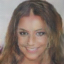

In [472]:
device = is_cuda_available()
ImgGer_OriginDCGAN = generator_original_DCGAN
ImgGer_OriginDCGAN.load_state_dict(torch.load("Saving_folder_OriginalDCGAN/generator_celeba_56.pt"))  # 56
ImgGer_OriginDCGAN = to_device(ImgGer_OriginDCGAN, device)

#--------------------------------------------------#
# Ensure reproducibility.
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

size_latent = 128

fixed_latent = torch.randn(36, size_latent, 1, 1, device = device)

generate_image_grid(generator      = ImgGer_OriginDCGAN    , 
                    latent_tensors = fixed_latent          ,
                    show           = False                 ,
                    image_folder   = 'Sample_Image_Output' ,
                    img_name       = "test_1"
                    )


generate_one_image(generator      = ImgGer_OriginDCGAN    , 
                   latent_tensors = fixed_latent          ,
                   show           = False                 ,
                   image_folder   = 'Sample_Image_Output' ,
                   img_name       = "test_1"              ,
                   img_selected   = 20                    ,
                    )

Image('./Sample_Image_Output/Generated_Images_test_1.png', width = 500, height = 500)



<br/>

## <font size="20"> &#8681; </font> Use Model - Enhanced DCGAN to generate images.

CUDA available. Running on GPU!
Saving Generated_Images_Grid_EDCGAN_test_2.png


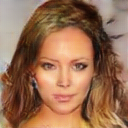

In [473]:
device = is_cuda_available()

generator_1 = generator_settings()
generator_1.load_state_dict(torch.load("Sample_Generator_Model_128/generator_celeba_50.pt"))
generator_1 = to_device(generator_1, device)

#--------------------------------------------------#
# Ensure reproducibility.
seed = 1624

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

size_latent = 128

fixed_latent = torch.randn(36, size_latent, 1, 1, device = device)


image_folder = "Sample_Image_Output"
img_name     = "EDCGAN_test_2"

generate_image_grid(generator      = generator_1           , 
                    latent_tensors = fixed_latent          ,
                    show           = False                 ,
                    image_folder   = image_folder          ,
                    img_name       = img_name              ,
                    )

generate_one_image(generator      = generator_1           , 
                   latent_tensors = fixed_latent          ,
                   show           = False                 ,
                   image_folder   = image_folder          ,
                   img_name       = img_name              ,
                   img_selected   = 33                    ,
                    )

Image( image_folder + "/Generated_Images_" + img_name + ".png", width = 500, height = 500)




<br/>

## <font size="20"> &#8681; </font> Showing Pre-saved Sample Output of Enhanced DCGAN

- The performance of enhanced DCGAN is not very stable. 
- Using a different random seed might get very bad result.
- Below are some good results that we have generated with the same model.

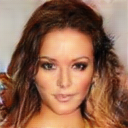

In [474]:

Image( image_folder + "/Generated_Images__" + img_name + ".png", width = 500, height = 500)


<br/>

## <font size="20"> &#8681; </font> Image Super Resolution

### Import a trained model

In [475]:
from Run_ESRGAN_Utils import *


### ESRGAN Model Architecture (Main)

In [476]:
# Model used for image super resolution, from, https://huggingface.co/spaces/Xhaheen/Face-Real-ESRGAN/tree/main.
# Model Main.

class RealESRGAN:
    def __init__(self, device, scale=4):
        self.device = device
        self.scale = scale
        self.model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=scale)
        
    def load_weights(self, model_path):
        loadnet = torch.load(model_path)
        if 'params' in loadnet:
            self.model.load_state_dict(loadnet['params'], strict=True)
        elif 'params_ema' in loadnet:
            self.model.load_state_dict(loadnet['params_ema'], strict=True)
        else:
            self.model.load_state_dict(loadnet, strict=True)
        self.model.eval()
        self.model.to(self.device)
        
    @torch.cuda.amp.autocast()
    def predict(self, lr_image, batch_size=4, patches_size=192,
                padding=24, pad_size=15):
        scale = self.scale
        device = self.device
        lr_image = np.array(lr_image)
        lr_image = pad_reflect(lr_image, pad_size)

        patches, p_shape = split_image_into_overlapping_patches(lr_image, patch_size=patches_size, 
                                                                padding_size=padding)
        img = torch.FloatTensor(patches/255).permute((0,3,1,2)).to(device).detach()

        with torch.no_grad():
            res = self.model(img[0:batch_size])
            for i in range(batch_size, img.shape[0], batch_size):
                res = torch.cat((res, self.model(img[i:i+batch_size])), 0)

        sr_image = res.permute((0,2,3,1)).clamp_(0, 1).cpu()
        np_sr_image = sr_image.numpy()

        padded_size_scaled = tuple(np.multiply(p_shape[0:2], scale)) + (3,)
        scaled_image_shape = tuple(np.multiply(lr_image.shape[0:2], scale)) + (3,)
        np_sr_image = stich_together(np_sr_image, padded_image_shape=padded_size_scaled,
                                target_shape=scaled_image_shape, padding_size=padding * scale)
        sr_img = (np_sr_image*255).astype(np.uint8)
        sr_img = unpad_image(sr_img, pad_size*scale)
        sr_img = PIL.Image.fromarray(sr_img)

        return sr_img

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2 = RealESRGAN(device, scale=2)
model2.load_weights('ESRGAN_weights/RealESRGAN_x2.pth')
model4 = RealESRGAN(device, scale=4)
model4.load_weights('ESRGAN_weights/RealESRGAN_x4.pth')
model8 = RealESRGAN(device, scale=8)
model8.load_weights('ESRGAN_weights/RealESRGAN_x8.pth')


def inference(image: Image, size: str) -> Image:
    if size == '2x':
        result = model2.predict(image.convert('RGB'))
    elif size == '4x':
        result = model4.predict(image.convert('RGB'))
    else:
        result = model8.predict(image.convert('RGB'))
    return result


def ESR_Image(input_image_path = "./Sample_Image_Output/Generated_Images_test_1.png"        ,
              image_folder     = "Sample_Image_Output"                                      ,
              sr_image_header  = "SR_"                                                      ,
              ):

    SR_img_nme = sr_image_header + input_image_path.split("/")[-1]

    ESR_Image_out = inference(PIL.Image.open(input_image_path, mode='r'), "x8")

    ESR_Image_out.save(Path(image_folder) / SR_img_nme)

    return ESR_Image_out

### Raise Image Resolution, test with a previously generated 64 * 64 image.

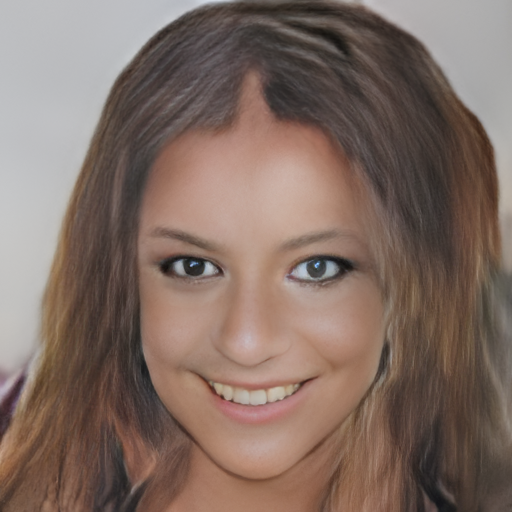

In [477]:
ESR_Image(input_image_path = "./Sample_Image_Output/Generated_Images_test_1.png"        ,
          image_folder     = "Sample_Image_Output"                                      ,
          sr_image_header  = "SR_"                                                      ,
          )

### Raise Image Resolution, test with a previously generated 128 * 128 image.

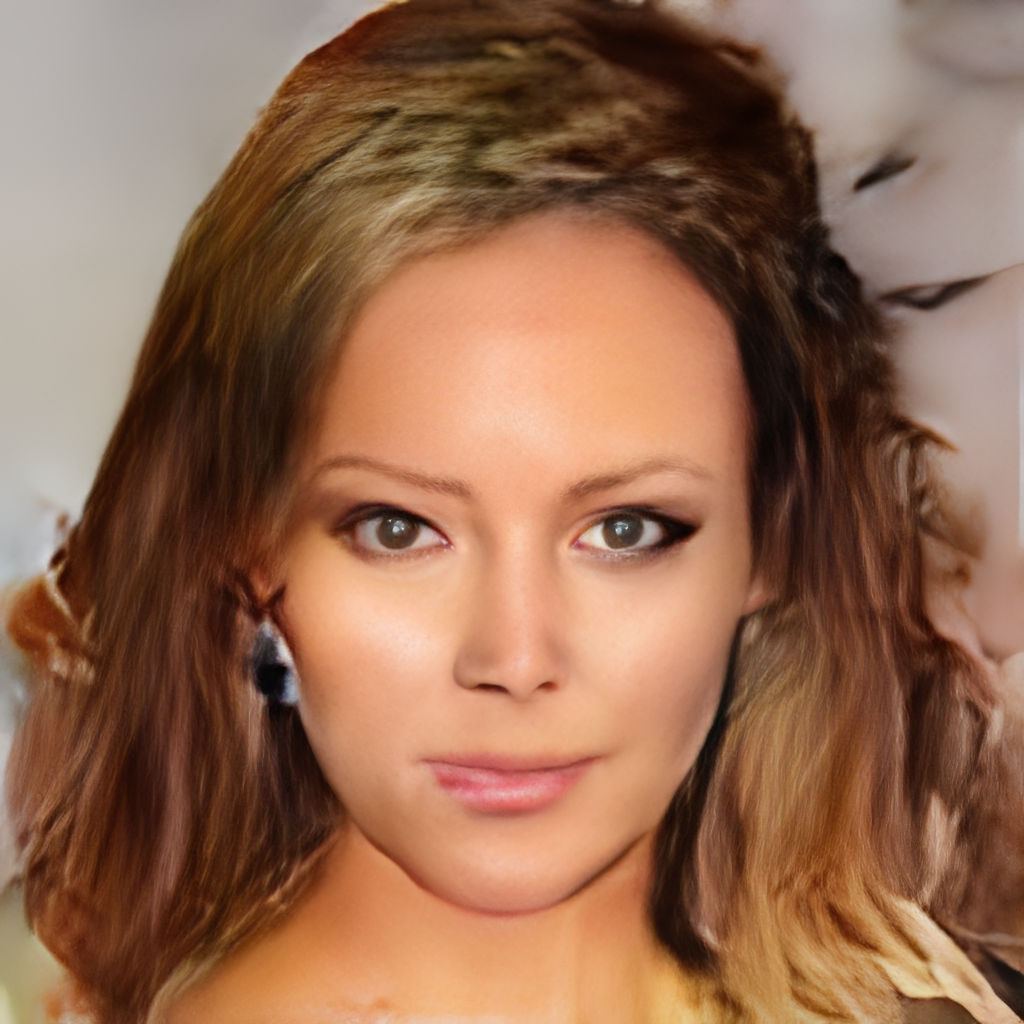

In [478]:
ESR_Image(input_image_path = "./Sample_Image_Output/Generated_Images_EDCGAN_test_2.png"        ,
          image_folder     = "Sample_Image_Output"                                             ,
          sr_image_header  = "SR_"                                                             ,
          )


<br/>

## <font size="20"> &#8681; </font> Define a function for user to try out.

In [504]:
def image_generator_sample(seed              =  42                   ,
                           img_save_location = 'Sample_Image_Output' ,
                           img_name          = "Test_Output"         , 
                           generator         =  ImgGer_OriginDCGAN   ,):
    

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    size_latent = 128

    fixed_latent = torch.randn(64, size_latent, 1, 1, device = device)

    generate_one_image(generator      = generator             , 
                       latent_tensors = fixed_latent          ,
                       show           = False                 ,
                       image_folder   = img_save_location     ,
                       img_name       = img_name              ,
                       img_selected   = 20                    ,
                       )

    ESR_Image_out = ESR_Image(input_image_path = img_save_location + "/Generated_Images_" + img_name + ".png"  ,
                              image_folder     = img_save_location                   ,
                              sr_image_header  = "SR_"                               ,
                              )
    
    
    return ESR_Image_out

# <center>  <font size="20"> &#9733; </font> **Image Generation TRY YOURSELF** <font size="20"> &#9733; </font> </center>



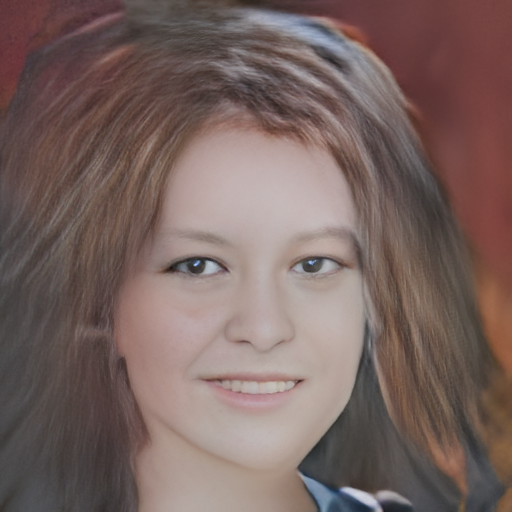

In [517]:
seed = 1234


ImgGer_OriginDCGAN_test = generator_original_DCGAN
ImgGer_OriginDCGAN_test.load_state_dict(torch.load("Saving_folder_OriginalDCGAN/generator_celeba_56.pt"))  # 56
ImgGer_OriginDCGAN_test = to_device(ImgGer_OriginDCGAN, device)

image_generator_sample(seed              =  seed                   ,
                       img_save_location = 'Sample_Image_Output'   ,
                       img_name          = "Test_Output"           , 
                       generator         = ImgGer_OriginDCGAN_test ,  )

